# Prerequisites

In [2]:
# install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git -q
!pip install pyclustering -q
!pip install "git+https://github.com/tqdm/tqdm.git@devel#egg=tqdm"
!git clone https://github.com/keras-team/keras-tuner -q
!pip install keras-tuner -q
!pip install git+https://github.com/paulgavrikov/visualkeras
!pip install git+http://github.com/fmfn/BayesianOptimization.git

^C
  Cloning https://github.com/tqdm/tqdm.git (to revision devel) to c:\users\bratu\appdata\local\temp\pip-install-6wubily5\tqdm_c06182047be94c958431d2d7703891c9
  Resolved https://github.com/tqdm/tqdm.git to commit 98f72896757e7e339c942a12af2752feefab4910
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for tqdm: filename=tqdm-4.62.2.dev2+g98f7289-py2.py3-none-any.whl size=76511 sha256=1b8e048b090e6b3fd218ee4c0053d55ef1422cadcc4b1fb0a9d5d5ae148edca8
  Stored in directory: C:\Users\bratu\AppData\Local\Temp\pip-ephem-wheel-cache-4hlolu5z\wheels\f1\58\54\d72aae0c3247efd40fa1ab18ef7a77c9be7c69953ed9ec71ff
Successfully built tqdm
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.61.2.dev2+gd2a6ec2

  Running command git clone -q https://github.com/tqdm/tqdm.git 'C:\Users\bratu\AppData\Local\Temp\pip-install-6wubily5\tqdm_c06182047be94c958431d2d7703891c9'
  Running command git checkout -b devel --track origin/devel
  Branch 'devel' set up to track remote branch 'devel' from 'origin'.
  Switched to a new branch 'devel'
fatal: destination path 'keras-tuner' already exists and is not an empty directory.


  Cloning https://github.com/paulgavrikov/visualkeras to c:\users\bratu\appdata\local\temp\pip-req-build-xpvmc623
  Resolved https://github.com/paulgavrikov/visualkeras to commit 39373a627f38a5880a1f9716089d77c2a6230722
  Using cached aggdraw-1.3.12-cp38-cp38-win_amd64.whl (42 kB)
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13042 sha256=10e1f8a0a3f20038fd3b224639ddf9ccc747b616ce4cefdfe2ef309ee9e4b96f
  Stored in directory: C:\Users\bratu\AppData\Local\Temp\pip-ephem-wheel-cache-5n9er4k6\wheels\e6\fe\80\74c54ccb79205ab57079259bc349e1629373e811e1c82ed535
Successfully built visualkeras

  Running command git clone -q https://github.com/paulgavrikov/visualkeras 'C:\Users\bratu\AppData\Local\Temp\pip-req-build-xpvmc623'



  Cloning http://github.com/fmfn/BayesianOptimization.git to c:\users\bratu\appdata\local\temp\pip-req-build-4fqsu505
  Resolved http://github.com/fmfn/BayesianOptimization.git to commit 91441fe4002fb6ebdb4aa5e33826230d8df560d0
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=13625 sha256=c2060c89ff4da7f20c1508b5023002ed702bc686d39f6f253ecdd5856d3d5422
  Stored in directory: C:\Users\bratu\AppData\Local\Temp\pip-ephem-wheel-cache-l7aebq4e\wheels\40\4d\7c\bdc87cf9606d3ef213031da377a5a030df71c36ff1603ded82
Successfully built bayesian-optimization


  Running command git clone -q http://github.com/fmfn/BayesianOptimization.git 'C:\Users\bratu\AppData\Local\Temp\pip-req-build-4fqsu505'


In [1]:
import math
import pickle
import random
import copy
import itertools
from math import sqrt
from typing import List
from copy import deepcopy
from tqdm import tqdm
from collections import Counter

import numpy as np
import kerastuner as kt
import pandas as pd
from tqdm import tqdm
from scipy import stats
from collections import namedtuple
from datetime import datetime, date, timedelta

from itertools import combinations

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from keras import backend
from typing import List
from IPython.display import clear_output

from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score as sh_score
from sklearn.decomposition import PCA

from pyclustering.cluster.optics import optics
import yfinance as yf

from finrl.config import config as finrl_config
from finrl.preprocessing.data import data_split
from finrl.env.env_portfolio import StockPortfolioEnv
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer

from scipy.spatial.distance import pdist, squareform
import datetime

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Mount Google Drive

# Constants

In [26]:
TIME_STEPS = 20
TIME_STEPS_COMMON = 8
COLS = ['open', 'high', 'low', 'close', 'volume']
NUM_FEATURES = len(COLS)
ROOT = 'weights'

# Dataset analysis

In [6]:
aapl = pd.read_csv(f'AAPL.txt', names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])
aapl['date'] = aapl['date'].apply(lambda x: '/'.join(x.split('/')[::-1]))
aapl[:20]

,date,time,open,high,low,close,volume
0,1998/02/01,09:30,13.6250,13.7500,13.5000,13.6875,202700
1,1998/02/01,09:45,13.6875,13.7500,13.5000,13.6250,334000
2,1998/02/01,10:00,13.6250,13.7500,13.5625,13.7500,299900
3,1998/02/01,10:15,13.7500,14.0000,13.6250,14.0000,430201
4,1998/02/01,10:30,13.9375,14.8125,13.7500,14.6250,944200
5,1998/02/01,10:45,14.6250,14.7500,14.3750,14.4375,218103
6,1998/02/01,11:00,14.4375,14.6875,14.3750,14.6250,463100
7,1998/02/01,11:15,14.6250,14.6250,14.5625,14.6250,130900
8,1998/02/01,11:30,14.6250,14.6250,14.5000,14.5000,135500
9,1998/02/01,11:45,14.5625,14.7500,14.5000,14.6250,118600


In [7]:
rolling_aapl = pd.DataFrame()
rolling_aapl['open'] = aapl['open'].groupby(aapl['open'].index // 4).apply(lambda arr: arr.iloc[0])
rolling_aapl['high'] = aapl['high'].groupby(aapl['high'].index // 4).max()
rolling_aapl['low'] = aapl['low'].groupby(aapl['low'].index // 4).min()
rolling_aapl['close'] = aapl['close'].groupby(aapl['close'].index // 4).apply(lambda arr: arr.iloc[-1])
rolling_aapl['volume'] = aapl['volume'].groupby(aapl['volume'].index // 4).sum()
rolling_aapl

,open,high,low,close,volume
0,13.6250,14.0000,13.5000,14.0000,1266801
1,13.9375,14.8125,13.7500,14.6250,1756303
2,14.6250,15.2500,14.5000,15.0625,669000
3,15.0625,15.3125,15.0000,15.3125,569100
4,15.3125,15.8750,15.3125,15.3750,660700
...,...,...,...,...,...
72367,120.7200,121.1700,120.6700,121.0300,14035592
72368,121.0300,121.0300,120.9500,121.0300,122431
72369,121.0200,121.1100,121.0100,121.0600,49839
72370,121.0600,121.1000,120.9700,121.0000,57417


# Data preparation

In [8]:
aapl[['open', 'high', 'low', 'close']]

,open,high,low,close
0,13.6250,13.7500,13.5000,13.6875
1,13.6875,13.7500,13.5000,13.6250
2,13.6250,13.7500,13.5625,13.7500
3,13.7500,14.0000,13.6250,14.0000
4,13.9375,14.8125,13.7500,14.6250
...,...,...,...,...
289482,120.9900,121.1000,120.9700,121.0900
289483,121.0600,121.1000,120.9900,121.0000
289484,121.0000,121.0700,120.9900,121.0300
289485,121.0100,121.0300,121.0000,121.0300


In [9]:
aapl[COLS] = np.log(aapl[COLS].values)

In [10]:
price_scaler = preprocessing.MinMaxScaler()
volume_scaler = preprocessing.MinMaxScaler()

aapl[['open', 'low', 'high', 'close']] = price_scaler.fit_transform(aapl[['open', 'low', 'high', 'close']])
aapl['volume'] = volume_scaler.fit_transform(aapl['volume'].values.reshape(-1, 1))

In [11]:
rows = aapl.shape[0]
cols = aapl.shape[1]
aapl, rows, cols

(              date   time      open      high       low     close    volume
 0       1998/02/01  09:30  0.020403  0.014996  0.042787  0.015767  0.562784
 1       1998/02/01  09:45  0.021539  0.014996  0.042787  0.014624  0.599697
 2       1998/02/01  10:00  0.020403  0.014996  0.043905  0.016904  0.591737
 3       1998/02/01  10:15  0.022670  0.019504  0.045018  0.021404  0.618405
 4       1998/02/01  10:30  0.026032  0.033617  0.047229  0.032310  0.676505
 ...            ...    ...       ...       ...       ...       ...       ...
 289482  2021/12/03  18:45  0.562532  0.559272  0.573536  0.560158  0.373959
 289483  2021/12/03  19:00  0.562675  0.559272  0.573576  0.559972  0.388435
 289484  2021/12/03  19:15  0.562552  0.559210  0.573576  0.560034  0.364261
 289485  2021/12/03  19:30  0.562573  0.559127  0.573596  0.560034  0.312981
 289486  2021/12/03  19:45  0.562614  0.559272  0.573636  0.560137  0.429197
 
 [289487 rows x 7 columns],
 289487,
 7)

In [12]:
Chunk = namedtuple('Chunk', 'df_chunk init_idx latent_vector')

In [13]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, split_size, time_steps_common) -> List[Chunk]: 
    chunks = list()
    num_chunks = len(df) // split_size + 1
    step = split_size - time_steps_common
    for i in range(0, len(df), step):
        if i >= len(df):
          break
        chunks.append(Chunk(df[i:i+split_size], i, None))
    return list(filter(lambda x: len(x.df_chunk) == TIME_STEPS, chunks))

In [14]:
chunks = split_dataframe(aapl[COLS], split_size=TIME_STEPS, time_steps_common=TIME_STEPS_COMMON)
len(chunks)

24123

In [15]:
chunks[0]

Chunk(df_chunk=        open      high       low     close    volume
0   0.020403  0.014996  0.042787  0.015767  0.562784
1   0.021539  0.014996  0.042787  0.014624  0.599697
2   0.020403  0.014996  0.043905  0.016904  0.591737
3   0.022670  0.019504  0.045018  0.021404  0.618405
4   0.026032  0.033617  0.047229  0.032310  0.676505
5   0.037985  0.032560  0.057987  0.029088  0.568198
6   0.034782  0.031497  0.057987  0.032310  0.623851
7   0.037985  0.030430  0.061124  0.032310  0.530464
8   0.037985  0.030430  0.060083  0.030167  0.533016
9   0.036922  0.032560  0.060083  0.032310  0.523170
10  0.039044  0.035720  0.062161  0.036543  0.537153
11  0.043234  0.040900  0.065244  0.039671  0.584411
12  0.045303  0.039872  0.068288  0.040705  0.573049
13  0.046331  0.041923  0.069295  0.042760  0.527173
14  0.049389  0.041923  0.069295  0.041735  0.524834
15  0.046331  0.041923  0.069295  0.043781  0.502528
16  0.049389  0.044968  0.073279  0.044799  0.530124
17  0.051407  0.044968  0.07426

In [16]:
ds = np.array(list(map(lambda x: x.df_chunk, chunks)))

In [17]:
ds.shape

(24123, 20, 5)

In [18]:
X_train, X_test = train_test_split(ds, train_size=0.8, shuffle = True)

In [19]:
X_train

array([[[0.57478178, 0.57152679, 0.5853097 , 0.57241088, 0.38745614],
        [0.57501604, 0.57174307, 0.5856525 , 0.57254829, 0.37146777],
        [0.57505506, 0.57184132, 0.58578568, 0.57264639, 0.31972985],
        ...,
        [0.57573693, 0.572528  , 0.58626072, 0.57333201, 0.40186532],
        [0.57583419, 0.57254759, 0.58635562, 0.57313631, 0.31453829],
        [0.57571747, 0.572332  , 0.58631767, 0.57313631, 0.33616209]],

       [[0.65585209, 0.65337174, 0.6641201 , 0.65345319, 0.40669614],
        [0.65554193, 0.65313052, 0.66262929, 0.65272829, 0.70417548],
        [0.65472805, 0.65223458, 0.66276771, 0.65245769, 0.66116533],
        ...,
        [0.65209011, 0.64954172, 0.66033378, 0.64964898, 0.60745668],
        [0.65167494, 0.64941208, 0.66012401, 0.64936059, 0.63338058],
        [0.6514169 , 0.64912374, 0.65994207, 0.64910076, 0.61370664]],

       [[0.44807984, 0.44396691, 0.4619891 , 0.44498763, 0.29044715],
        [0.44811238, 0.44396691, 0.46202082, 0.44508573, 0.2

In [20]:
train_tensor = tf.convert_to_tensor(X_train)
test_tensor = tf.convert_to_tensor(X_test)

In [21]:
train_tensor

<tf.Tensor: shape=(19298, 20, 5), dtype=float64, numpy=
array([[[0.57478178, 0.57152679, 0.5853097 , 0.57241088, 0.38745614],
        [0.57501604, 0.57174307, 0.5856525 , 0.57254829, 0.37146777],
        [0.57505506, 0.57184132, 0.58578568, 0.57264639, 0.31972985],
        ...,
        [0.57573693, 0.572528  , 0.58626072, 0.57333201, 0.40186532],
        [0.57583419, 0.57254759, 0.58635562, 0.57313631, 0.31453829],
        [0.57571747, 0.572332  , 0.58631767, 0.57313631, 0.33616209]],

       [[0.65585209, 0.65337174, 0.6641201 , 0.65345319, 0.40669614],
        [0.65554193, 0.65313052, 0.66262929, 0.65272829, 0.70417548],
        [0.65472805, 0.65223458, 0.66276771, 0.65245769, 0.66116533],
        ...,
        [0.65209011, 0.64954172, 0.66033378, 0.64964898, 0.60745668],
        [0.65167494, 0.64941208, 0.66012401, 0.64936059, 0.63338058],
        [0.6514169 , 0.64912374, 0.65994207, 0.64910076, 0.61370664]],

       [[0.44807984, 0.44396691, 0.4619891 , 0.44498763, 0.29044715],
    

# The Autoencoder

## Setup AE

In [22]:
DROP_RATE = 0.3
LATENT_SPACE_DIM = 12

In [23]:
encoder_input = keras.Input(shape=(TIME_STEPS, NUM_FEATURES))
x = layers.Conv1D(256, 4, padding='same')(encoder_input)
x = layers.PReLU()(x)
x = layers.Dropout(DROP_RATE)(x)
x = layers.Conv1D(256, 4, padding='same')(x)
x = layers.PReLU()(x)
x = layers.Dropout(DROP_RATE)(x)
x = layers.Conv1D(256, 4, padding='same')(x)
x = layers.PReLU()(x)
x = layers.Dropout(DROP_RATE)(x)
x = layers.LSTM(units=256, kernel_initializer='he_uniform', return_sequences=True)(x)
x = layers.PReLU()(x)
x = layers.Dropout(DROP_RATE)(x)
x = layers.LSTM(units=256, kernel_initializer='he_uniform', return_sequences=True)(x)
x = layers.PReLU()(x)
x = layers.Dropout(DROP_RATE)(x)
encoder_output = layers.LSTM(units=LATENT_SPACE_DIM, kernel_initializer='he_uniform', return_sequences=False)(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')


decoder_input = keras.Input(shape=(LATENT_SPACE_DIM,))
x = layers.RepeatVector(TIME_STEPS)(decoder_input)
x = layers.LSTM(units=256, kernel_initializer='he_uniform', return_sequences=True)(x)
x = layers.PReLU()(x)
x = layers.Dropout(DROP_RATE)(x)
x = layers.LSTM(units=256, kernel_initializer='he_uniform', return_sequences=True)(x)
x = layers.PReLU()(x)
x = layers.Dropout(DROP_RATE)(x)
x = layers.Conv1D(256, 4, padding='same')(x)
x = layers.PReLU()(x)
x = layers.Dropout(DROP_RATE)(x)
x = layers.Conv1D(256, 4, padding='same')(x)
x = layers.PReLU()(x)
x = layers.Dropout(DROP_RATE)(x)
x = layers.Conv1D(256, 4, padding='same')(x)
x = layers.PReLU()(x)
x = layers.Dropout(DROP_RATE)(x)
x = layers.TimeDistributed(layers.Dense(NUM_FEATURES))(x)
decoder_output = layers.TimeDistributed(layers.ReLU(max_value=1.0))(x)
decoder = keras.Model(decoder_input, decoder_output, name='decoder')

# Setup checkpoints
checkpoint_path=f'{ROOT}/weights'
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

ae_input = keras.Input(shape=(TIME_STEPS, NUM_FEATURES), name='encoder_input')
ae_encoding = encoder(ae_input)
ae_decoding = decoder(ae_encoding)
autoencoder = keras.Model(ae_input, ae_decoding, name="autoencoder")

encoder.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.00001, nesterov=True), loss='mse')
decoder.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.00001, nesterov=True), loss='mse')
autoencoder.compile(optimizer='adam', loss='mse')

In [24]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 20, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 256)           275456    
_________________________________________________________________
p_re_lu_5 (PReLU)            (None, 20, 256)           5120      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 20, 256)           5120

In [25]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model = self.model

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model = self.model

## Train AE

In [31]:
# best_model_cb = SaveBestModel()

# autoencoder.fit(
#     x=train_tensor,
#     y=train_tensor,
#     validation_data=(test_tensor, test_tensor),
#     epochs=1000, shuffle=True, batch_size=64, callbacks=[best_model_cb])

# autoencoder = best_model_cb.best_model

# autoencoder.save_weights(f'{checkpoint_path}/autoencoder-log-alt.weights')
# autoencoder.get_layer('decoder').save_weights(f'{checkpoint_path}/decoder-log-alt.weights')
# autoencoder.get_layer('encoder').save_weights(f'{checkpoint_path}/encoder-log-alt.weights')

## Load AE

In [29]:
autoencoder.load_weights(f'{ROOT}/autoencoder-log-alt.weights')
decoder.load_weights(f'{ROOT}/decoder-log-alt.weights')
encoder.load_weights(f'{ROOT}/encoder-log-alt.weights')

## Check results

In [30]:
predictions = autoencoder.predict(test_tensor)

autoencoder.evaluate(test_tensor)

for (y, y_hat) in itertools.islice(zip(test_tensor, predictions), 5):
  print(f'ACTUAL TIME SERIES:')
  print(y)
  print(f'DECODED TIME SERIES:')
  print(y_hat)
  print('########')

151/151 [==============================] - 1s 760us/step - loss: 0.0000e+00
ACTUAL TIME SERIES:
tf.Tensor(
[[0.44804731 0.44468646 0.46004631 0.44295154 0.72768895]
 [0.44621833 0.4426533  0.45892451 0.44199345 0.73897328]
 [0.44526585 0.44176271 0.45895664 0.44179476 0.69524314]
 [0.4450354  0.44076942 0.45682728 0.44043283 0.73822367]
 [0.44373094 0.44080259 0.45669762 0.44139692 0.72357676]
 [0.44460684 0.44083576 0.45708638 0.44126416 0.7073058 ]
 [0.44447483 0.44060349 0.45747452 0.44029956 0.68834512]
 [0.4435819  0.44040423 0.45737754 0.44119776 0.72557842]
 [0.44447483 0.44136587 0.45782976 0.44113134 0.5199885 ]
 [0.44440879 0.440371   0.45821671 0.44119776 0.35609472]
 [0.44457384 0.440371   0.45782976 0.44136374 0.3255263 ]
 [0.44457384 0.44017155 0.45837776 0.44116455 0.30393731]
 [0.44447483 0.44017155 0.45831335 0.44129736 0.30649423]
 [0.44457384 0.44053709 0.45831335 0.44159592 0.34995525]
 [0.44480473 0.44057029 0.45782976 0.44162907 0.55773171]
 [0.44490361 0.44063668

In [31]:
latent_vectors = encoder.predict(tf.convert_to_tensor(ds))

In [32]:
latent_vectors, latent_vectors.shape

(array([[-0.39861548, -0.03944566,  0.27158204, ..., -0.11444458,
          0.07899548, -0.05214661],
        [-0.2906114 , -0.01206935,  0.18873441, ..., -0.05542064,
          0.10372353, -0.04873171],
        [-0.2632178 , -0.2141946 ,  0.21472318, ...,  0.06679375,
          0.08967863, -0.0856787 ],
        ...,
        [-0.0977696 ,  0.05081162,  0.34469345, ..., -0.05255457,
         -0.12060191, -0.02156346],
        [-0.14612226, -0.00444959,  0.3201872 , ..., -0.13124855,
          0.04075433,  0.06133635],
        [-0.11986099, -0.08506288,  0.07533296, ..., -0.21336697,
          0.13933961,  0.08093411]], dtype=float32),
 (24123, 12))

In [33]:
corr_df = pd.DataFrame(latent_vectors)

<AxesSubplot:>

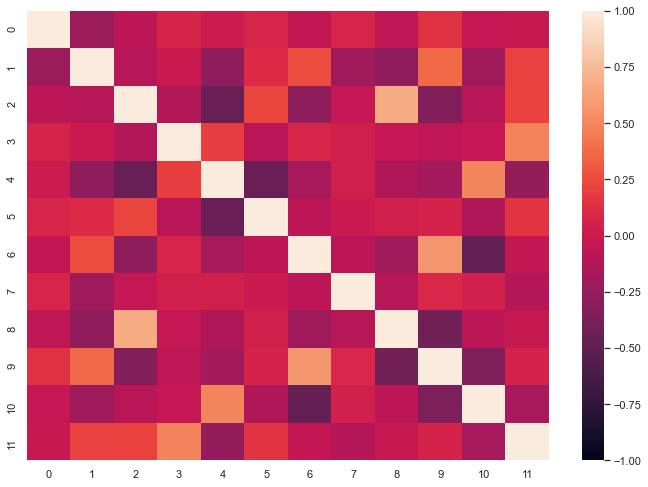

In [34]:
sns.heatmap(corr_df.corr(), vmin=-1, vmax=1)

# Clustering

## Analyse distances between points

In [35]:
from scipy.spatial.distance import pdist, squareform

distances = squareform(pdist(latent_vectors))

In [36]:
distances.shape

(24123, 24123)

In [37]:
NUM_STEPS = 10
eps_range = np.linspace(0.15, 0.25, NUM_STEPS)

with open(f'eps_range_aapl', 'wb+') as f:
  pickle.dump(eps_range, f)

In [38]:
with open(f'eps_range_aapl', 'rb') as f:
  eps_range = pickle.load(f)

## Training clusters

In [41]:
clusterings = []
for eps in tqdm(eps_range):
  optics_instance = optics(latent_vectors, eps, 3)
  optics_instance.process()
  clusterings.append(optics_instance) 

results = {}
for eps, inst in zip(eps_range, clusterings):
  results[eps] = { 
      'noise': inst.get_noise(),
      'clusters': inst.get_clusters()
  } 

with open(f'{ROOT}/appl-{TIME_STEPS}-{TIME_STEPS_COMMON}-{NUM_STEPS}', 'wb+') as f:
  pickle.dump(results, f)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:15<00:00, 13.53s/it]


In [42]:
TIME_STEPS, TIME_STEPS_COMMON, NUM_STEPS

(20, 8, 10)

## Loading clusters

In [44]:
with open(f'{ROOT}/appl-{TIME_STEPS}-{TIME_STEPS_COMMON}-{NUM_STEPS}', 'rb') as f:
  results = pickle.load(f)

# Clustering analysis

In [45]:
def normalize_labels(latent_vectors, clusters, noise_cluster):
  labels = [0 for _ in range(len(latent_vectors))]
  for c_idx, cluster in enumerate(clusters):
    for member in cluster:
      labels[member] = c_idx
  for member in noise_cluster:
    labels[member] = -1
  return labels

In [46]:
latent_vectors.shape

(24123, 12)

In [47]:
clustering_labels = {}
for k, v in results.items():
  clustering_labels[k] = normalize_labels(latent_vectors, v['clusters'], v['noise'])

In [48]:
def get_cluster(latent_vectors, labels, label):
  # Get all points belonging to cluster labeled [label]
  result = []
  for lv, l in zip(latent_vectors, labels):
    if l == label:
      result.append(lv)
  return np.array(result)

In [49]:
def calculate_cluster_variance(observations: np.ndarray):
  # Calculate the variance of the set of observations
  mean = observations.mean()
  var = 0.0
  for o in observations:
    var += ((o - mean) ** 2).sum()
  return var

In [50]:
total_var = calculate_cluster_variance(latent_vectors)
total_var

10466.423843063414

## Find ideal epsilon

In [51]:
plot = []
for eps in list(clustering_labels.keys()):
  labels = clustering_labels[eps]
  exp_var = 0.0
  for l in set(labels):
    if l == -1:
      continue
    cluster = get_cluster(latent_vectors, labels, l)
    exp_var += calculate_cluster_variance(cluster)
  plot.append((eps, exp_var/total_var))

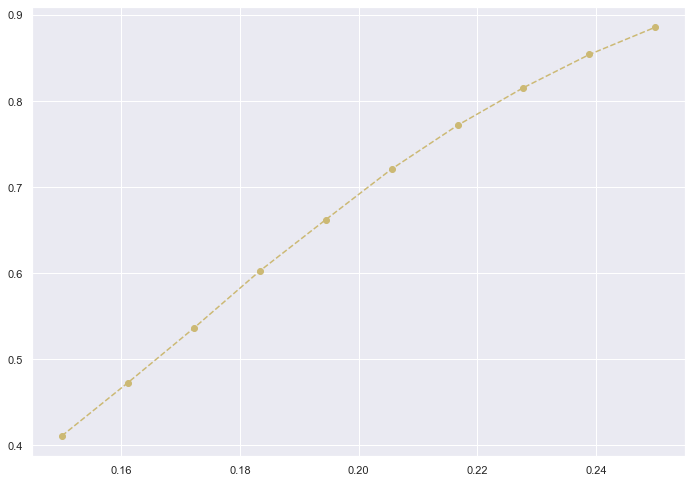

In [52]:
plt.plot([p[0] for p in plot], [p[1] for p in plot], 'yo--')

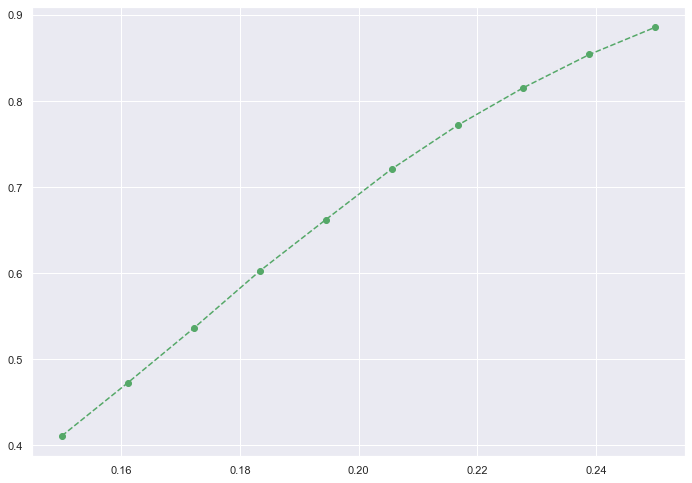

In [53]:
plt.plot([p[0] for p in plot][:20], [p[1] for p in plot][:20], 'go--')

In [54]:
labels = list(clustering_labels.values())[7]
pts_majority = [x[0] for x in zip(latent_vectors, labels) if x[1] == 0]
pts_non_majority = [x[0] for x in zip(latent_vectors, labels) if x[1] != 0]
Counter(labels)

Counter({0: 21204,
         -1: 2786,
         1: 3,
         2: 9,
         3: 6,
         4: 6,
         5: 8,
         6: 6,
         7: 3,
         8: 5,
         9: 2,
         10: 3,
         11: 2,
         12: 3,
         13: 2,
         14: 1,
         15: 2,
         16: 3,
         17: 4,
         18: 6,
         19: 3,
         20: 4,
         21: 11,
         22: 9,
         23: 6,
         24: 2,
         25: 4,
         26: 4,
         27: 3,
         28: 3,
         29: 3,
         30: 1,
         31: 2,
         32: 2,
         33: 2})

## PCA 3D visualization of latent space

In [62]:
pca_init = PCA(n_components=3)
pca_latent = pca_init.fit_transform(latent_vectors)

In [63]:
pca_latent, pca_latent.shape

(array([[ 0.43618414,  0.58003575,  0.01388557],
        [ 0.5185512 ,  0.738597  , -0.04199301],
        [ 0.50816774,  0.5034655 ,  0.01869515],
        ...,
        [-0.44651148,  0.01395809, -0.43308407],
        [-0.36147994,  0.04021222, -0.30494076],
        [-0.3446716 , -0.1096531 ,  0.10183307]], dtype=float32),
 (24123, 3))

# GAN Network

## Define network

In [82]:
class ClipConstraint(tf.keras.constraints.Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [83]:
def wasserstein_loss(y_true, y_pred):
  return backend.mean(y_true * y_pred)

class GAN:

  def __init__(self, real_data: List, batch_size: int):
    self.real_data = tf.convert_to_tensor(real_data)
    self.batch_size = batch_size
    self.data_size = self.real_data.shape[1]
    self.noise_size = 15

    const = ClipConstraint(0.05)

    critic_input = keras.Input(shape=(self.data_size, 1))
    x = layers.Conv1D(16, 4, 2, padding='same', kernel_constraint=const)(critic_input)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(16, 4, 2, padding='same', kernel_constraint=const)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(16, 4, 2, padding='same', kernel_constraint=const)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, kernel_constraint=const)(x)
    critic_output = layers.Dense(1, activation='linear')(x)
    critic = keras.Model(critic_input, critic_output, name='critic')
    critic.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001))

    generator_input = keras.Input(shape=(self.noise_size, 1))
    x = layers.Dense(20)(generator_input)
    x = layers.Conv1D(16, 4, 2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(16, 4, 2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100)(x)
    x = layers.Dense(100)(x)
    generator_output = layers.Dense(self.data_size)(x)
    generator = keras.Model(generator_input, generator_output, name='generator')
    
    # Define the combined generator and critic model, for updating the generator
    self.gan = keras.Sequential()
    self.gan.add(generator)
    self.gan.add(critic)
    self.gan.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001))

  def _get_noise(self, how_many: int):
    # Sample random noise
    x_input = np.random.randn(how_many, self.noise_size)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(how_many, self.noise_size)
    return x_input

  def _clip_weights(self):
    for l in self.gan.get_layer('critic').layers:
      weights = l.get_weights()
      weights = [np.clip(w, -0.01, 0.01) for w in weights]
      l.set_weights(weights)

  def train(self, num_epochs=1000, disc_steps=5):
    for i in range(num_epochs):
      d_real_all = []
      d_fake_all = []
      
      # Unfreeze the generator so we can train it
      self.gan.get_layer('critic').trainable = True

      for j in range(disc_steps):
        # Train the critic [disc_steps] times as often
        X_real = tf.convert_to_tensor([random.choice(self.real_data) for k in range(self.batch_size)])
        y_real = tf.convert_to_tensor([-1.0 for k in range(self.batch_size)])

        noise_batch = self._get_noise(self.batch_size)
        X_fake = self.gan.get_layer('generator').predict(noise_batch)
        y_fake = tf.convert_to_tensor([1.0 for k in range(self.batch_size)])

        real_l = self.gan.get_layer('critic').train_on_batch(X_real, y_real)
        self._clip_weights()
        fake_l = self.gan.get_layer('critic').train_on_batch(X_fake, y_fake)
        self._clip_weights()
        d_real_all.append(real_l)
        d_fake_all.append(fake_l)
      
      # Freeze the critic so we can update only the generator
      self.gan.get_layer('critic').trainable = False

      noise_batch = self._get_noise(self.batch_size)
      # INVERSE THE LABELS IN ORDER TO INCETIVISE THE GENERATOR TOWARDS REAL
      y_fake = tf.convert_to_tensor([-1.0 for k in range(self.batch_size)])
      g_loss = self.gan.train_on_batch(noise_batch, y_fake)
        
      # Recall that the Wasserstein loss seeks scores for real and fake that are more different during training
      # The benefit of the WGAN is that the loss correlates with generated image quality. Lower loss means better quality images, for a stable training process
      print(f'EPOCH {i+1} CRIT REAL {np.mean(d_real_all)} CRIT FAKE {np.mean(d_fake_all)} GENR {g_loss}')
      self.gan.save_weights(f'{checkpoint_path}/gan-log-3.weights')

      if (i+1) % 20 == 0:
        clear_output(wait=False)
        self.benchmark()
        self.gan.save_weights(f'{checkpoint_path}/gan-log-3.weights')
  
  def generate_examples(self, num_examples: int):
    noise = self._get_noise(num_examples)
    return self.gan.get_layer('generator').predict(noise)
  
  def benchmark(self, num=10):
    noise = self._get_noise(num)
    real = tf.convert_to_tensor([random.choice(self.real_data) for k in range(num)])
    print(f"FAKE\n{self.gan.predict(noise)}\nREAL\n{self.gan.get_layer('critic').predict(real)}")
    return self.gan.get_layer('generator').predict(noise), self.gan.get_layer('critic').predict(real)

In [86]:
gan = GAN(pts_non_majority, batch_size=64)

In [84]:
# gan.train(num_epochs=200, disc_steps=20)
# gan.gan.save_weights(f'{ROOT}/gan-log-3.weights')

## Training and preparing fakes

In [87]:
gan.gan.load_weights(f'{ROOT}/gan-log-3.weights')

In [88]:
gan.gan.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Functional)       (None, 12)                20188     
_________________________________________________________________
critic (Functional)          (None, 1)                 5561      
Total params: 25,749
Trainable params: 25,749
Non-trainable params: 0
_________________________________________________________________


In [89]:
gan.gan.get_layer('generator').summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 15, 1)]           0         
_________________________________________________________________
dense_3 (Dense)              (None, 15, 20)            40        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 8, 16)             1296      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 16)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 4, 16)             1040      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0 

In [90]:
pts_non_majority_t = tf.convert_to_tensor(pts_non_majority)

In [91]:
pts_non_majority_t[0]

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([-0.2906114 , -0.01206935,  0.18873441, -0.54608124, -0.340461  ,
       -0.06134724, -0.03871496,  0.51779324,  0.11520461, -0.05542064,
        0.10372353, -0.04873171], dtype=float32)>

In [92]:
decoder.predict(pts_non_majority_t).shape

(2919, 20, 5)

## Generate fakes

In [93]:
fake_examples = gan.generate_examples(2919)

In [108]:
!pip install ipympl

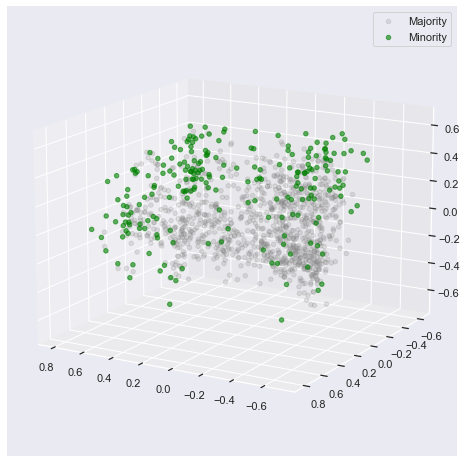

In [192]:
ax = plt.axes(projection='3d')

# pca_maj = pca_init.transform(pts_majority)
# mask = np.random.choice([False, True], len(pca_maj), p=[0.95, 0.05])
# pca_maj = pca_maj[mask]

# pca_min = pca_init.transform(pts_non_majority)
# mask = np.random.choice([False, True], len(pca_min), p=[0.92, 0.08])
# pca_min = pca_min[mask]

# pca_fake = pca_init.transform(fake_examples)
# mask = np.random.choice([False, True], len(pca_fake), p=[0.92, 0.08])
# pca_fake = pca_fake[mask]

# pca_fake_bordered = []
# for x in pca_fake:
#     if any([v > 0.8 or v < -0.8 for v in x]):
#         continue
#     pca_fake_bordered.append(x)
# pca_fake = np.array(pca_fake_bordered)

maj = ax.scatter3D(pca_maj[:, 0], pca_maj[:, 1], pca_maj[:, 2], c='grey', alpha=0.2, marker='o')
nonmaj = ax.scatter3D(pca_min[:, 0], pca_min[:, 1], pca_min[:, 2], c='green',alpha=0.6, marker='o')
# fake = ax.scatter3D(pca_fake[:, 0], pca_fake[:, 1], pca_fake[:, 2], c='red', alpha=0.6, marker='o')
# ax.set_title('Majority and minority points distribution')
ax.legend([maj, nonmaj], ['Majority', 'Minority'])
# ax.set_title('Majority, minority and generated points distribution')
# ax.legend([maj, nonmaj, fake], ['Majority', 'Minority', 'Generated'])

ax.view_init(elev=15, azim=120)

In [70]:
decoder.predict(fake_examples).shape

(2919, 20, 5)

In [71]:
np.array(pts_non_majority).shape

(2919, 12)

In [72]:
pnm_df = pd.DataFrame(pts_non_majority)
pnm_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.290611,-0.012069,0.188734,-0.546081,-0.340461,-0.061347,-0.038715,0.517793,0.115205,-0.055421,0.103724,-0.048732
1,-0.263218,-0.214195,0.214723,-0.339556,-0.110675,0.074956,-0.052716,0.471068,0.125437,0.066794,0.089679,-0.085679
2,-0.133759,0.173298,0.342326,-0.564784,-0.218631,0.259299,-0.098261,0.305348,0.087232,0.169084,-0.198754,-0.164711
3,-0.044600,0.032486,0.393923,-0.457022,-0.187116,-0.095602,-0.179738,0.401243,-0.125618,-0.111320,0.136679,-0.047606
4,-0.023935,-0.094080,0.255595,-0.486529,-0.253267,-0.188835,-0.126538,0.532069,0.145826,0.010506,-0.104612,-0.068177
...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-0.103215,0.175290,0.320947,0.225412,-0.488490,0.287575,-0.118537,0.500052,0.053928,-0.014576,-0.257693,0.101007
2915,-0.132599,-0.099102,-0.059437,0.381783,0.289663,-0.265213,0.036844,0.465412,-0.001449,0.006046,0.060676,0.123346
2916,-0.090910,-0.007915,-0.091570,0.255393,-0.043288,0.167167,0.131810,0.478587,-0.193937,0.289847,0.154536,0.126080
2917,-0.105453,0.057376,0.127530,0.391568,-0.013333,-0.045720,-0.118098,0.370095,0.036993,-0.047905,0.383159,-0.006004


## Correlation comparison with minority

<AxesSubplot:>

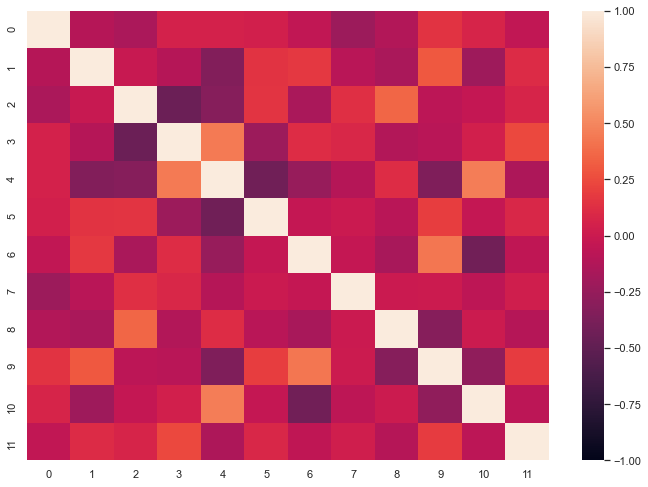

In [73]:
sns.heatmap(pnm_df.corr(), vmin=-1, vmax=1)

<AxesSubplot:>

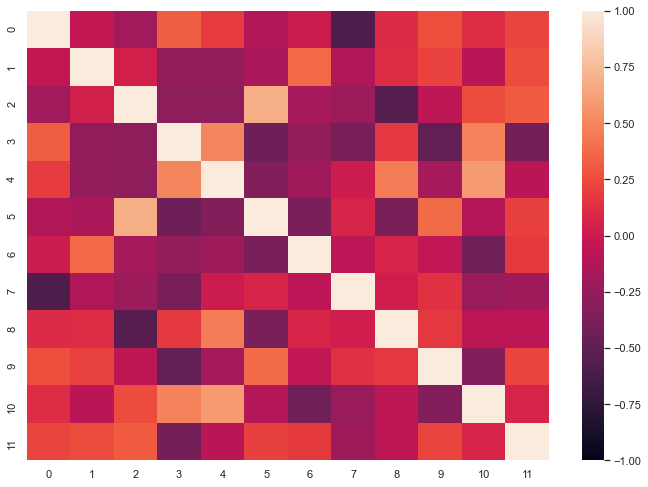

In [74]:
sns.heatmap(pd.DataFrame(fake_examples).corr(), vmin=-1, vmax=1)
# gan.generate_examples(3935).shape

<AxesSubplot:>

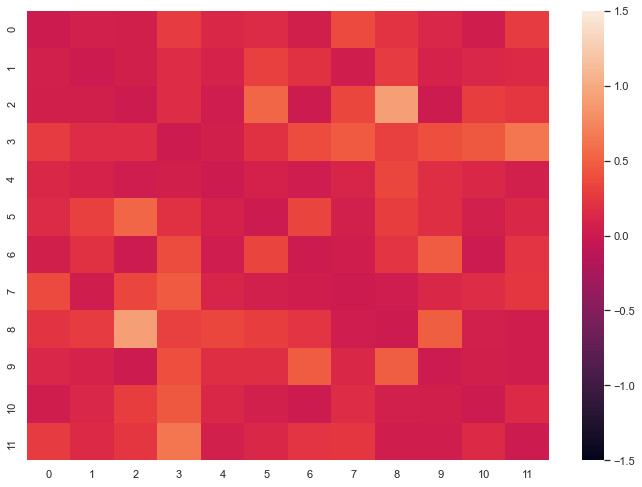

In [75]:
sns.heatmap((pnm_df.corr() - pd.DataFrame(fake_examples).corr()).abs(), vmin=-1.5, vmax=1.5)

In [76]:
pts_non_majority_np = np.array(pts_non_majority)
fake_examples = gan.generate_examples(pts_non_majority_np.shape[0])

In [77]:
pts_non_majority_np.shape

(2919, 12)

In [78]:
fake_examples = np.array(fake_examples)
fake_examples.shape

(2919, 12)

In [79]:
fake_examples.shape

(2919, 12)

## Multivariate Wilcoxon

In [80]:
def multivariate_wilcoxon(distr_one, distr_two):
  def sgn(val):
    if val == 0: return 0
    return val / abs(val)

  distr_one_np = np.array(distr_one)
  distr_two_np = np.array(distr_two)

  print(distr_one.shape, distr_two.shape)

  p, n = distr_one_np.shape
  assert (p, n) == distr_two_np.shape
  D = np.sum(distr_one - distr_two, 1, keepdims=True)
  assert (p, 1) == D.shape
  V = np.zeros((p, p))
  X = distr_one_np - distr_two_np
  X_sgn = np.vectorize(sgn)(X)
  for i in range(p):
    for j in range(p):
      V[i, j] = (1/n) * np.dot(X_sgn[i, :], X_sgn[j, :])
  D_star = np.transpose(D) @ np.linalg.inv(n * V) @ D
  D_star = D_star[0, 0]
  degrees_freedom = p
  return 1 - stats.chi2.cdf(D_star, df=degrees_freedom)

In [81]:
multivariate_wilcoxon(np.transpose(fake_examples), np.transpose(pts_non_majority_np))

(12, 2919) (12, 2919)


0.8466267602077453

In [82]:
np.transpose(fake_examples).shape

(12, 2919)

In [83]:
decoded_fake = decoder.predict(fake_examples)

# Integrating fakes

## Smoothing out fakes

In [84]:
def _scale_back(fake_sample: List[List]) -> pd.DataFrame:
  fake_df = pd.DataFrame(fake_sample, columns=COLS)
  fake_df[['open', 'low', 'high', 'close']] = price_scaler.inverse_transform(fake_df[['open', 'low', 'high', 'close']].values)
  fake_df['volume'] = volume_scaler.inverse_transform(fake_df['volume'].values.reshape(-1, 1))
  for col in COLS:
    fake_df[col] = np.exp(fake_df[col])
  return fake_df

In [85]:
_scale_back(decoded_fake[145])

,open,high,low,close,volume
0,128.731583,129.088776,128.333252,128.650696,3.639195e+06
1,128.680023,129.037445,128.233124,128.582993,3.902801e+06
2,129.504135,129.885834,129.023361,129.488937,5.318873e+05
3,130.256546,130.603455,129.862167,130.264236,2.291412e+05
4,129.281769,129.619781,128.921646,129.278625,2.653879e+05
5,129.480545,129.776627,129.163330,129.471466,1.706689e+05
6,129.220627,129.494568,128.920593,129.225311,1.156397e+05
7,128.809738,129.053131,128.536774,128.815399,7.068367e+04
8,128.938354,129.155334,128.672226,128.961792,3.012545e+04
9,128.858276,129.064529,128.624573,128.907745,1.330604e+04


In [86]:
from bayes_opt import BayesianOptimization

In [87]:
def time_step_passes(timestep: List[float]) -> bool:
    # Input: One timestep unit
    high_is_high = timestep[0] <= timestep[1] and timestep[2] <= timestep[1] and timestep[3] <= timestep[1]
    low_is_low = timestep[0] >= timestep[2] and timestep[1] >= timestep[2] and timestep[3] >= timestep[2]
    return high_is_high and low_is_low

def to_batch(np_input):
  return tf.expand_dims(
    tf.convert_to_tensor(np_input), 0
  )

def generate_valid_fakes(s_count: int):
  def black_box_first_wrapper(scaled_d_fake_l, volume, fake_latent):
    def black_box_function_first(open, high, low, close):
      if not time_step_passes([open, high, low, close, volume]):
        return -1
      changed_np = copy.deepcopy(scaled_d_fake_l)
      changed_np[idx_t] = [open, high, low, close, volume]
      changed_latent = encoder.predict(to_batch(changed_np))
      dist = np.linalg.norm(changed_latent-fake_latent)
      # Library attempts to maximize, so we return the inverse of the distance
      return 1 / dist
    return black_box_function_first

  def black_box_general_wrapper(scaled_d_fake_l, open, volume, fake_latent):
    def black_box_function_general(high, low, close):
      if not time_step_passes([open, high, low, close, volume]):
        return -1
      changed_np = copy.deepcopy(scaled_d_fake_l)
      changed_np[idx_t] = [open, high, low, close, volume]
      changed_latent = encoder.predict(to_batch(changed_np))
      dist = np.linalg.norm(changed_latent-fake_latent)
      # Library attempts to maximize, so we return the inverse of the distance
      return 1 / dist
    return black_box_function_general

  # Filter out examples generated by GAN 
  fake_examples = []
  fake_batch = gan.generate_examples(s_count)
  decoded_batch = decoder.predict(fake_batch)
 
  for idx in tqdm(range(len(fake_batch))):
    d_fake = decoded_batch[idx]
    fake_latent = fake_batch[idx]
    scaled_d_fake = _scale_back(d_fake)
    scaled_d_fake_l = scaled_d_fake.values
    
    # Validate generated examples
    for idx_t in range(len(scaled_d_fake_l)):
      time_step = scaled_d_fake_l[idx_t] 
      if not time_step_passes(time_step):
        open, high, low, close, volume = time_step
        # Generate new values and append volume
        if idx_t == 0:
          bounds = {
            'open': (open - np.sqrt(open), open + np.sqrt(open)),
            'high': (high - np.sqrt(high), high + np.sqrt(high)),
            'low': (low - np.sqrt(low), low + np.sqrt(low)),
            'close': (close - np.sqrt(close), close + np.sqrt(close))
          }
          optimizer = BayesianOptimization(
            f=black_box_first_wrapper(scaled_d_fake_l, volume, fake_latent),
            pbounds=bounds,
            random_state=1,
          )
        else:
          bounds = {
            'high': (high - np.sqrt(high), high + np.sqrt(high)),
            'low': (low - np.sqrt(low), low + np.sqrt(low)),
            'close': (close - np.sqrt(close), close + np.sqrt(close))
          }
          optimizer = BayesianOptimization(
            f=black_box_general_wrapper(scaled_d_fake_l, open, volume, fake_latent),
            pbounds=bounds,
            random_state=1,
          )
        optimizer.maximize(
          init_points=5,
          n_iter=5,
        )
        best_params = optimizer.max['params']
        if idx_t == 0:
          scaled_d_fake_l[idx_t][0] = best_params['open']
        scaled_d_fake_l[idx_t][1] = best_params['high']
        scaled_d_fake_l[idx_t][2] = best_params['low']
        scaled_d_fake_l[idx_t][3] = best_params['close']
        if idx_t + 1 < len(scaled_d_fake_l):
          scaled_d_fake_l[idx_t + 1, 0] = scaled_d_fake_l[idx_t, -2]
    clear_output(wait=False)
    fake_examples.append((
      fake_latent,
      encoder.predict(to_batch(scaled_d_fake_l)),
      pd.DataFrame(scaled_d_fake_l, columns=COLS))
    )
    if len(fake_examples) % 20 == 0:
      clear_output(wait=False)
  return fake_examples

In [88]:
ROOT

'/content/gdrive/MyDrive/thesis'

In [89]:
with open(f'valid_fakes', 'rb') as fp:
  all_valid_fake_examples = pickle.load(fp)

In [90]:
# # all_valid_fake_examples = []
# for i in range(50):
#   valid_fake_examples = generate_valid_fakes(50)
#   all_valid_fake_examples.extend(valid_fake_examples)
#   with open(f'{ROOT}/valid_fakes', 'wb+') as fp:
#     pickle.dump(all_valid_fake_examples, fp)

In [91]:
len(all_valid_fake_examples)

128

In [92]:
len(pts_non_majority)

2919

In [94]:
all_valid_fake_examples[117]

,open,high,low,close,volume
0,293.914124,294.764221,293.374878,294.137177,275120.468750
1,313.488373,322.726929,295.394714,312.033600,165204.812500
2,312.033600,313.113373,311.714539,312.362213,193206.250000
3,309.593140,309.978119,308.941650,309.486877,182285.765625
4,306.659241,306.884064,306.008636,306.320435,278594.281250
5,302.354675,302.715637,301.951141,302.131287,204947.421875
6,304.539551,305.081970,303.807556,304.664642,199747.281250
7,301.955566,302.285889,301.335663,301.664459,258156.890625
8,302.393311,302.871124,301.744720,302.387146,229778.812500
9,304.642670,305.231873,303.920288,304.847870,182839.750000


## Prepare original samples

In [121]:
aapl = pd.read_csv(f'AAPL.txt', names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])
chunks = split_dataframe(aapl[COLS], split_size=TIME_STEPS, time_steps_common=TIME_STEPS_COMMON)
len(chunks)

24123

In [122]:
chunks = list(map(lambda x: x.df_chunk, chunks))

In [123]:
def get_interval_prices(chunks):
  interval_prices = []
  for idx_t in range(len(chunks)):
    if idx_t < len(chunks)-1:
      first_close_price = chunks[idx_t]['close'].values[-1]
      next_open_price = chunks[idx_t+1]['open'].values[0]
      vol_average = np.hstack((chunks[idx_t]['volume'].values, chunks[idx_t+1]['volume'].values))
      vol_average = np.average(vol_average)
      interval_prices.append(np.array((first_close_price, next_open_price, vol_average)))
  return interval_prices

In [103]:
get_interval_prices(chunks)[:10]

[array([1.53750000e+01, 1.50625000e+01, 2.48120575e+05]),
 array([1.64375000e+01, 1.56875000e+01, 2.45053525e+05]),
 array([1.56875000e+01, 1.60000000e+01, 1.76493275e+05]),
 array([1.58750000e+01, 1.53750000e+01, 1.15372975e+05]),
 array([1.49375000e+01, 1.58750000e+01, 4.69525075e+05]),
 array([1.83125000e+01, 1.94375000e+01, 7.29801425e+05]),
 array([1.76250000e+01, 1.80625000e+01, 4.33031825e+05]),
 array([1.74375000e+01, 1.76250000e+01, 2.35260425e+05]),
 array([1.76250000e+01, 1.71875000e+01, 2.27205525e+05]),
 array([1.8250000e+01, 1.7750000e+01, 2.3797335e+05])]

In [104]:
len(all_valid_fake_examples)

128

In [105]:
augmented_chunks = deepcopy(chunks)

In [106]:
def euclidian_dist(x, y):
  return np.linalg.norm(x-y)

best_indices = []
for fake in tqdm(all_valid_fake_examples):
  open_p = fake[2]['open'].values[0]
  close_p = fake[2]['close'].values[-1]
  best_idx = None
  best_dist = float('inf')
  interval_prices = get_interval_prices(augmented_chunks) 
  for idx, interval in enumerate(interval_prices):
    dist = euclidian_dist(np.array((open_p, close_p, np.average(fake[2]['volume'].values))), interval)
    if dist < best_dist:
      best_dist = dist
      best_idx = idx
  augmented_chunks.insert(best_idx+1, fake[2])

In [ ]:
with open(f'{ROOT}/augmented', 'wb+') as fp:
  pickle.dump(augmented_chunks, fp)

In [108]:
with open(f'augmented', 'rb') as fp:
  augmented_chunks = pickle.load(fp)

In [109]:
def add_date(df):
  start = datetime.datetime(1998, 5, 5, 8, 0)
  delta = datetime.timedelta(minutes=15)
  step = deepcopy(start)
  series = []
  for i in range(len(df)):
    series.append(step)
    step += delta
  df['date'] = series
  return df

In [110]:
len(chunks), len(augmented_chunks)

In [111]:
def add_date(df):
  start = datetime.datetime(1998, 5, 5, 8, 0)
  delta = datetime.timedelta(minutes=15)
  step = deepcopy(start)
  series = []
  for i in range(len(df)):
    series.append(step)
    step += delta
  df['date'] = series
  return df

In [112]:
full_df
full_df['tic'] = 'AAPL'

In [113]:
full_df = add_date(full_df)

In [114]:
full_df

## Final test

__Code below is very taxing, just load datasets again__

In [115]:
full_df = FeatureEngineer(use_technical_indicator=True, use_turbulence=False).preprocess_data(full_df.copy())

In [116]:
augmented_chunks = pd.concat(augmented_chunks)
augmented_chunks['tic'] = 'AAPL'
augmented_chunks = add_date(augmented_chunks)
augmented_df = FeatureEngineer(use_technical_indicator=True, use_turbulence=False).preprocess_data(augmented_chunks.copy())

In [117]:
# add covariance matrix as states
for df in [full_df]:
  df=df.sort_values(['date','tic'],ignore_index=True)
  df.index = df.date.factorize()[0]
  cov_list = []
  lookback=252
  for i in tqdm(range(lookback,len(df.index.unique()))):
    data_lookback = df.loc[i-lookback:i,:]
    price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values 
    cov_list.append(covs)
    
  df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
  df = df.merge(df_cov, on='date')
  df = df.sort_values(['date','tic']).reset_index(drop=True)

In [119]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv

class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs